In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1D 컨브넷 구현

- 케라스에서 1D 컨브넷은 `Conv1D` 층을 사용하여 구현합니다. 
- `Conv1D`는 `Conv2D`와 인터페이스가 비슷합니다. `(samples, time, features)` 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다. 
- 합성곱 윈도우는 시간 축의 1D 윈도우입니다. 즉, 입력 텐서의 두 번째 축입니다.

- 간단한 두 개 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
17473536/17464789 [==============================] - 1s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

# 모델 정보 출력
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


157/157 [==============================] - 13s 12ms/step - loss: 0.7058 - acc: 0.5294 - val_loss: 0.6835 - val_acc: 0.5806
Epoch 2/10
157/157 [==============================] - 1s 9ms/step - loss: 0.6624 - acc: 0.6750 - val_loss: 0.6606 - val_acc: 0.6520
Epoch 3/10
157/157 [==============================] - 1s 9ms/step - loss: 0.6158 - acc: 0.7671 - val_loss: 0.6006 - val_acc: 0.7458
Epoch 4/10
157/157 [==============================] - 1s 9ms/step - loss: 0.5201 - acc: 0.8159 - val_loss: 0.4772 - val_acc: 0.8134
Epoch 5/10
157/157 [==============================] - 1s 9ms/step - loss: 0.4040 - acc: 0.8500 - val_loss: 0.4109 - val_acc: 0.8394
Epoch 6/10
157/157 [==============================] - 1s 9ms/step - loss: 0.3393 - acc: 0.8773 - val_loss: 0.3972 - val_acc: 0.8490
Epoch 7/10
157/157 [==============================] - 1s 9ms/step - loss: 0.2993 - acc: 0.8943 - val_loss: 0.4104 - val_acc: 0.8586
Epoch 8/10
157/157 [==============================] - 1s 9ms/step - loss: 0.2672 - ac

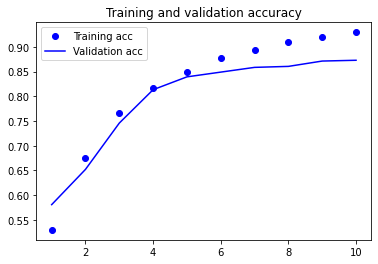

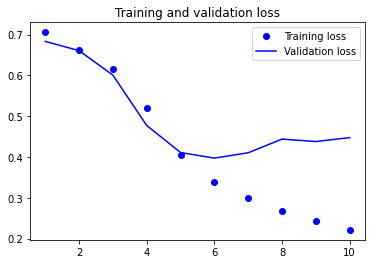

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


검증 정확도 LSTM 보다는 낮지만 CPU, GPU 에서 더 빠르게 실행된다.~
단어 수준의 감성분류 작업에 순환 네트워크를 대신하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있다.

CNN과 RNN을 연결하여 긴 시퀀스를 처리하기

In [ ]:
import os
import numpy as np

data_dir = '/content/drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

[과제] 상기 건에 대하여 CNN을 이용하여 모델 학습 밒 검증을 수행한 후 그 성능이 상식 수준의 기준점과 비교하세요.

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


500/500 [==============================] - 10s 18ms/step - loss: 0.4186 - val_loss: 0.4562
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3601 - val_loss: 0.4624
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3382 - val_loss: 0.4889
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3217 - val_loss: 0.5034
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3124 - val_loss: 0.4746
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3020 - val_loss: 0.4713
Epoch 7/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2928 - val_loss: 0.4656
Epoch 8/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2850 - val_loss: 0.4796
Epoch 9/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2800 - val_loss: 0.4696
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2723 - val_loss: 0.4872

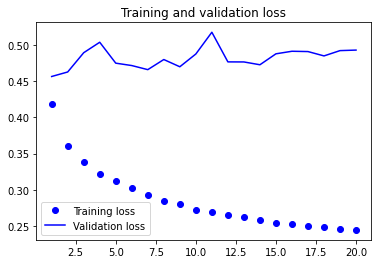

In [ ]:
import matplotlib.pyplot as plt
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#상식수준 0.3

[과제] 제나 데이터넷 step을 6대신 3으로 적용후 cnn,rnn연결하는 방식으로 수행후 그 성능을 평가

In [ ]:
lookback = 1440
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GRU(32, dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


500/500 [==============================] - 250s 494ms/step - loss: 0.3290 - val_loss: 0.3206
Epoch 2/20
500/500 [==============================] - 244s 489ms/step - loss: 0.2950 - val_loss: 0.2874
Epoch 3/20
500/500 [==============================] - 244s 487ms/step - loss: 0.2810 - val_loss: 0.2779
Epoch 4/20
500/500 [==============================] - 244s 488ms/step - loss: 0.2707 - val_loss: 0.2800
Epoch 5/20
500/500 [==============================] - 244s 487ms/step - loss: 0.2628 - val_loss: 0.2799
Epoch 6/20
500/500 [==============================] - 243s 487ms/step - loss: 0.2583 - val_loss: 0.2859
Epoch 7/20
500/500 [==============================] - 243s 486ms/step - loss: 0.2514 - val_loss: 0.2789
Epoch 8/20
500/500 [==============================] - 243s 486ms/step - loss: 0.2461 - val_loss: 0.2846
Epoch 9/20
500/500 [==============================] - 244s 487ms/step - loss: 0.2400 - val_loss: 0.2962
Epoch 10/20
500/500 [==============================] - 243s 486ms/step - lo

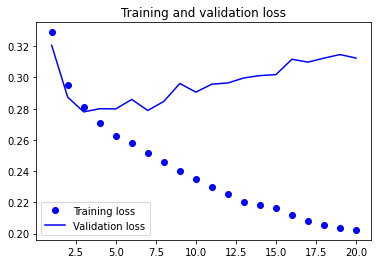

In [ ]:
import matplotlib.pyplot as plt
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#